# Chazam

<img src='images/chazam.png' width='500'/>

In [1]:
# librerias

from pydub import AudioSegment  # cargar audio

import pylab as plt     # para pintar

import matplotlib.mlab as mlab   # para sacar espectrograma

import numpy as np   # un poco de algebra lineal😁

import warnings    # para no imprimir warnings
warnings.filterwarnings('ignore')

### 01 - Audio

In [2]:
# carga de audio

nombre = 'Yello - Oh Yeah'

cancion = AudioSegment.from_file('audio/'+ nombre + '.wav')

In [3]:
cancion

### 02 - Señal (waveform)

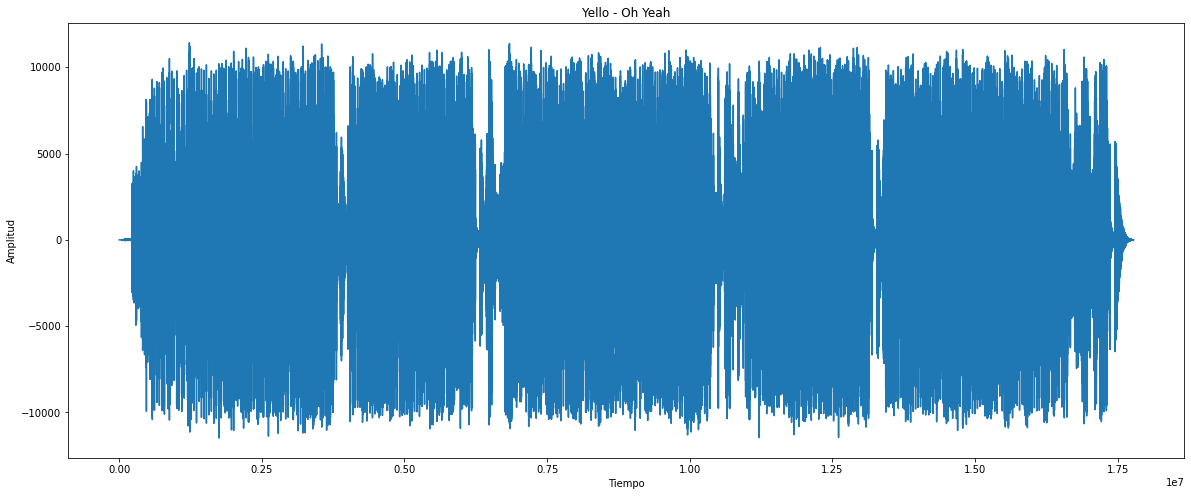

In [4]:
# gráfico de la señal de audio (amplitud vs tiempo)

plt.figure(figsize=(20, 8))

plt.plot(cancion.get_array_of_samples())

plt.title(nombre)

plt.xlabel('Tiempo')

plt.ylabel('Amplitud');

### 03 - Espectrograma

In [5]:
cancion.channels

2

In [6]:
# extraccion de un solo canal, 2 canales (cancion.channels)

canal = np.frombuffer(cancion.raw_data, np.int16)[0::2]

In [7]:
canal.shape   # dimension

(8889714,)

In [8]:
canal[int(8e6) : int(8e6) + 10]   # muestra

array([  671,   788,   624,  -221, -1133,  -691,   425,   246, -1017,
       -1937], dtype=int16)

In [9]:
# transformada de Fourier, extraccion componentes de frecuencia

espectro = mlab.specgram(
                        canal,
                        NFFT=5000,
                        Fs=48000,
                        window=mlab.window_hanning,
                        noverlap=int(5000 * 0.7)
                        )[0]


espectro.shape

(2501, 5924)

In [10]:
espectro[0][50:60]

array([0.02202285, 0.00562962, 0.00561666, 0.01077246, 0.0180843 ,
       0.03435744, 0.03099035, 0.01473767, 0.03006329, 0.01282584])

In [11]:
# transformacion logaritmica, mlab devuelve un array lineal, se excluyes los 0 para evitar warnings (me salen igual🤨)
# para graficar 

espectro = 10 * np.log10(espectro, out=np.zeros_like(espectro), where=(espectro != 0))

espectro[0][50:60]

array([-16.57126542, -22.49520663, -22.50522165, -19.6768494 ,
       -17.42698357, -14.63979253, -15.08773547, -18.31571132,
       -15.21963485, -18.9191434 ])

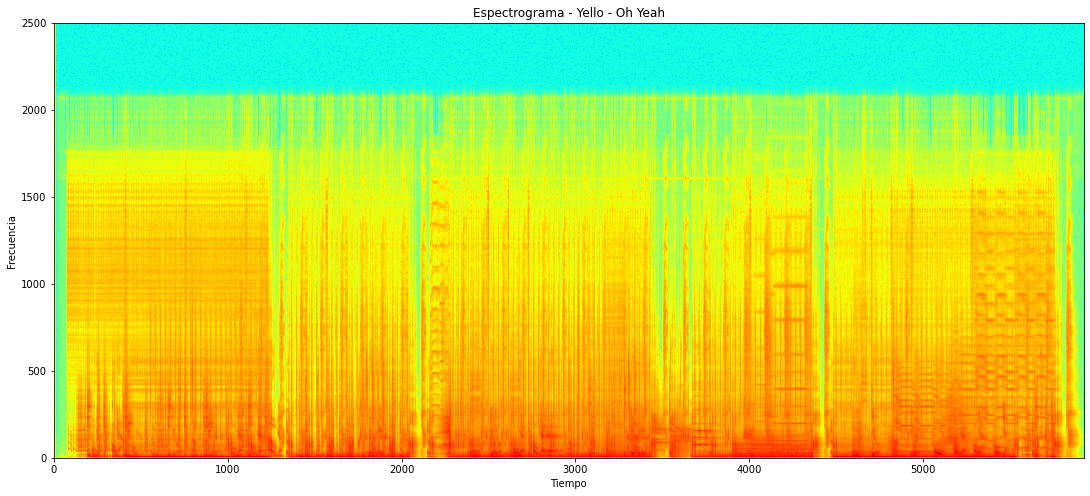

In [12]:
# gráfico del espectrograma (frecuencia vs tiempo: ejes. amplitud: color)

plt.figure(figsize=(20, 8))

plt.imshow(espectro, cmap='jet')

plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')

plt.title(f'Espectrograma - {nombre}')

plt.gca().invert_yaxis();

![eq](images/eq.gif)

### 04 - Extraer picos en el espectrograma

In [13]:
from chazam.logic.fingerprint import get_spectrum_peaks

In [14]:
picos = get_spectrum_peaks(espectro)

len(picos)

5503

In [15]:
picos[0]

(5, 100)

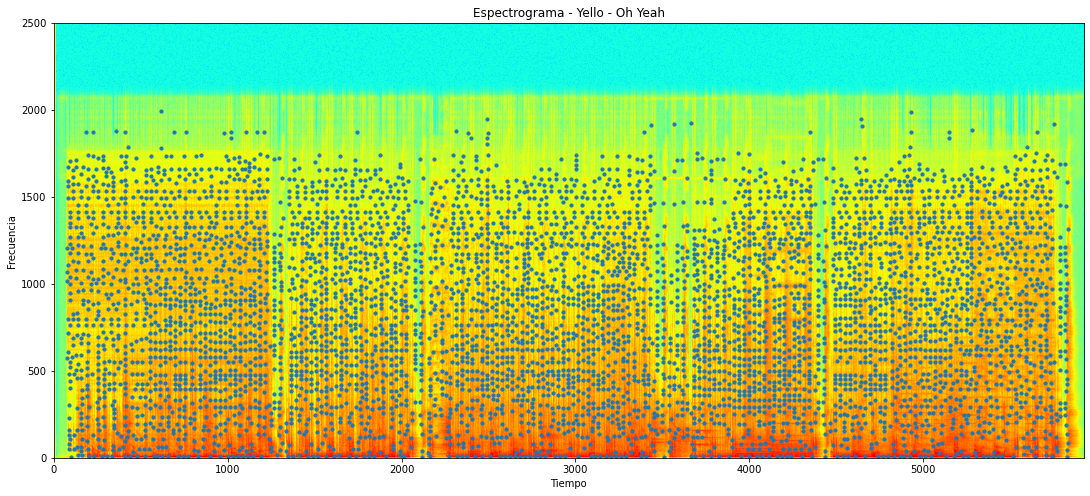

In [16]:
# espectrograma con picos

plt.figure(figsize=(20, 8))

plt.imshow(espectro, cmap='jet')

plt.scatter([e[1] for e in picos], [e[0] for e in picos], s=10)

plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')

plt.title(f'Espectrograma - {nombre}')

plt.gca().invert_yaxis();

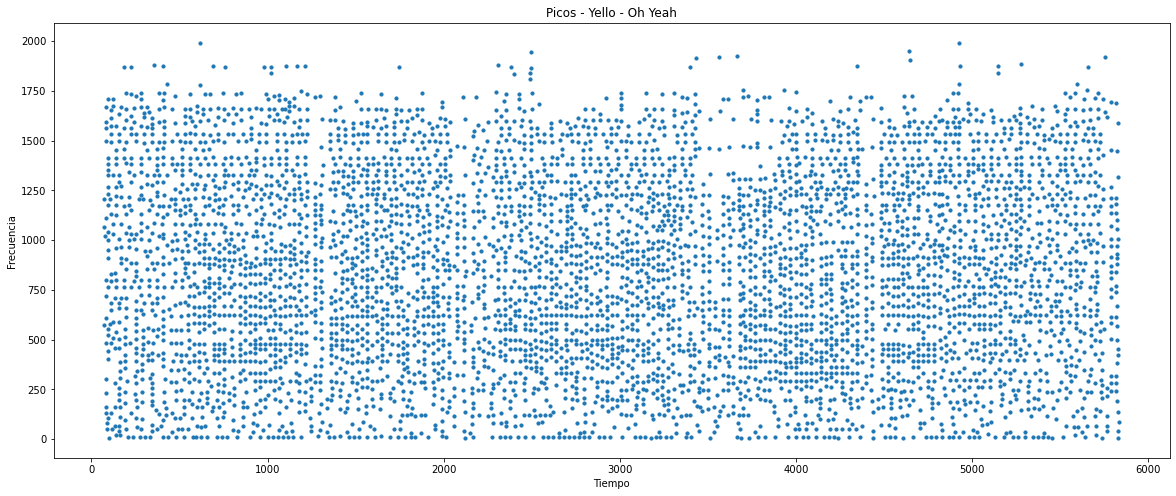

In [17]:
# picos

plt.figure(figsize=(20, 8))

plt.scatter([e[1] for e in picos], [e[0] for e in picos], s=10)

plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')

plt.title(f'Picos - {nombre}');

### 05 - Hashing fingerprints

<img src='images/fingerprint.jpg' width='500'/>

[funcion hash](https://es.wikipedia.org/wiki/Funci%C3%B3n_hash)


$hashing(\text{picos}, \text{diferencia tiempo entre picos}) = \text{valor hash del fingerprint, tiempo inicial}$

In [18]:
from chazam.logic.fingerprint import hashing

In [19]:
hash=hashing(picos, 15)

hash[-10:]

[('c89ee272db43092902b3', 5828),
 ('af33a2ff32a016b5d13e', 5828),
 ('9152abf3f6f9c81dcd0a', 5828),
 ('87ff24af19ab29f1eeda', 5828),
 ('908fcba2c1a86e76abec', 5829),
 ('7ff0d95dc6adb20f758a', 5829),
 ('d8ecd62220512c4d85ac', 5829),
 ('2a1152b96877fe4ed042', 5829),
 ('22fc3b997ac837623262', 5829),
 ('1174255c789bc92c9228', 5830)]

In [20]:
len(hash)

76937

### 06 - Base de datos (SQL)

**Creación tabla de canciones**


```sql
create table if not exists songs (
                
                song_id mediumint unsigned not null auto_increment,
                song_name varchar(250) not null,
                fingerprinted tinyint default 0,
                file_sha1 binary(20) not null,
                total_hashes int not null default 0,
                date_created  datetime not null default current_timestamp,
                date_modified datetime not null default current_timestamp on update current_timestamp,

               constraint pk_songs_song_id primary key (song_id),
               constraint uq_songs_song_id unique key (song_id)
    
         );
```

**Creacion tabla de fingerprints**

```sql
create table if not exists fingerprints (
    
                    hash binary(10) not null,
                    song_id mediumint unsigned not null,
                    offset int unsigned not null,
                    date_created  datetime not null default current_timestamp,
                    date_modified datetime not null default current_timestamp on update current_timestamp,
                   
    
   index ix_fingerprints_hash (hash),

   constraint uq_fingerprints_song_id_offset_hash unique key (song_id, offset, hash),
   constraint fk_fingerprints_song_id foreign key (song_id) references fingerprints(song_id) on delete cascade
            );

```

**Inserción de datos en tabla canciones**

```sql
insert into songs (song_name, file_sha1, total_hashes) 
       values (song_name_data, UNHEX(file_sha1_data), total_hashes_data);
```

**Inserción de datos en tabla fingerprints**

```sql
insert ignore into fingerprints (hash, song_id, offset) 
              values (UNHEX(hash_data), song_id_data, offset_data);
```

**búsqueda de canción**

```sql
select HEX(hash), song_id, offset from fingerprints where hash in (hash_data);
```

### 07 - Detección

In [21]:
from chazam.tools.audio import audio_cutting

In [22]:
# recorte de audio a detectar desde 1:50 hasta 1:53

audio_cutting(nombre, 1, 50, 1, 53)

In [23]:
AudioSegment.from_file('sample/'+ nombre + '.wav')

In [24]:
from chazam import Chazam

ih_chazam=Chazam()

In [25]:
cancion=ih_chazam.recognize('sample/'+ nombre + '.wav')

cancion

{'total_time': 0.2970390319824219,
 'fingerprint_time': 0.1266651153564453,
 'query_time': 0.1543269157409668,
 'align_time': 0.014314889907836914,
 'results': [{'song_id': 11,
   'song_name': b'Yello - Oh Yeah',
   'input_total_hashes': 6789,
   'fingerprinted_hashes_in_db': 603396,
   'hashes_matched_in_input': 5781,
   'input_confidence': 0.85,
   'fingerprinted_confidence': 0.01,
   'offset': 4400,
   'offset_seconds': 990.0,
   'file_sha1': b'20957650F0A24B0F9A18FF8636DF6CDF93B8E6E8'}]}

In [26]:
cancion['results'][0]['song_name'].decode('utf-8')

'Yello - Oh Yeah'

### 08 - API (deploy)

```python

from flask import Flask, request
from flask_cors import CORS        # cross-origin resource sharing

from chazam import Chazam

from config import WAV_PATH, COVERS, DATA_DEFAULT


app=Flask(__name__)

cors=CORS(app, resources={r'*': {'origins': '*'}})

ih_chazam=Chazam()


@app.route('/', methods=['POST', 'GET'])
def main():

    audio=request.files['blob']
    audio.save(WAV_PATH)

    song=ih_chazam.recognize(WAV_PATH)

    if song['results'][0]['input_confidence']<0.04:
        return f'{DATA_DEFAULT}', 200

    else:

        song_name=song['results'][0]['song_name'].decode('utf-8').split('-')

        data={'artist': song_name[0].strip(),
              'song': song_name[1].strip(),
              'cover': COVERS[song['results'][0]['song_name'].decode('utf-8')],
              'match_time': song['total_time']
              }

        return f'{data}', 200

   
if __name__== '__main__':
    app.run(debug=True)




```